# 数据插值

## 数据准备

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [30]:
name_list = ['id', 'latitude', 'longitude', 'altitude', 'year', 'month', 'day', 'avg_temp', 'max_temp',
             'min_temp', 'col1', 'col2', 'col3']
raw_data = pd.read_table("./数据集/插值数据/SURF_CLI_CHN_MUL_DAY-TEM-12001-201905.TXT",
                         header=None, sep='\t')
raw_data = raw_data[0].apply(lambda x: pd.Series([float(i.strip()) for i in x.split(' ') if i != ''], index=name_list))
raw_data

,id,latitude,longitude,altitude,year,month,day,avg_temp,max_temp,min_temp,col1,col2,col3
0,50136.0,5258.0,12231.0,4385.0,2019.0,5.0,1.0,59.0,169.0,-49.0,9.0,9.0,9.0
1,50136.0,5258.0,12231.0,4385.0,2019.0,5.0,2.0,119.0,254.0,-40.0,9.0,9.0,9.0
2,50136.0,5258.0,12231.0,4385.0,2019.0,5.0,3.0,88.0,170.0,7.0,9.0,9.0,9.0
3,50136.0,5258.0,12231.0,4385.0,2019.0,5.0,4.0,40.0,82.0,-8.0,9.0,9.0,9.0
4,50136.0,5258.0,12231.0,4385.0,2019.0,5.0,5.0,35.0,131.0,-78.0,9.0,9.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21670,59855.0,1913.0,11029.0,233.0,2019.0,5.0,27.0,291.0,329.0,268.0,9.0,9.0,9.0
21671,59855.0,1913.0,11029.0,233.0,2019.0,5.0,28.0,281.0,336.0,251.0,9.0,9.0,9.0
21672,59855.0,1913.0,11029.0,233.0,2019.0,5.0,29.0,274.0,334.0,251.0,9.0,9.0,9.0
21673,59855.0,1913.0,11029.0,233.0,2019.0,5.0,30.0,251.0,338.0,237.0,9.0,9.0,9.0


In [169]:
clean_data = raw_data.loc[(raw_data['year'] == 2019) & (raw_data['month'] == 5), :].groupby(
    ['latitude', 'longitude']).agg(
    avg_temp=('avg_temp', 'mean')
).reset_index()

for index in ['latitude', 'longitude']:
    clean_data[index] = clean_data[index] * 0.01
clean_data = clean_data.loc[(clean_data['longitude'] > 20) & (clean_data['latitude'] > 10), :]
clean_data

,latitude,longitude,avg_temp
130,19.13,110.29,1326.032258
131,19.31,109.35,278.387097
132,20.14,110.10,272.900000
133,20.15,110.10,282.285714
135,21.28,101.35,270.466667
...,...,...,...
794,51.40,124.23,89.363636
795,51.40,124.24,101.050000
796,51.44,126.38,114.709677
797,52.21,124.43,97.903226


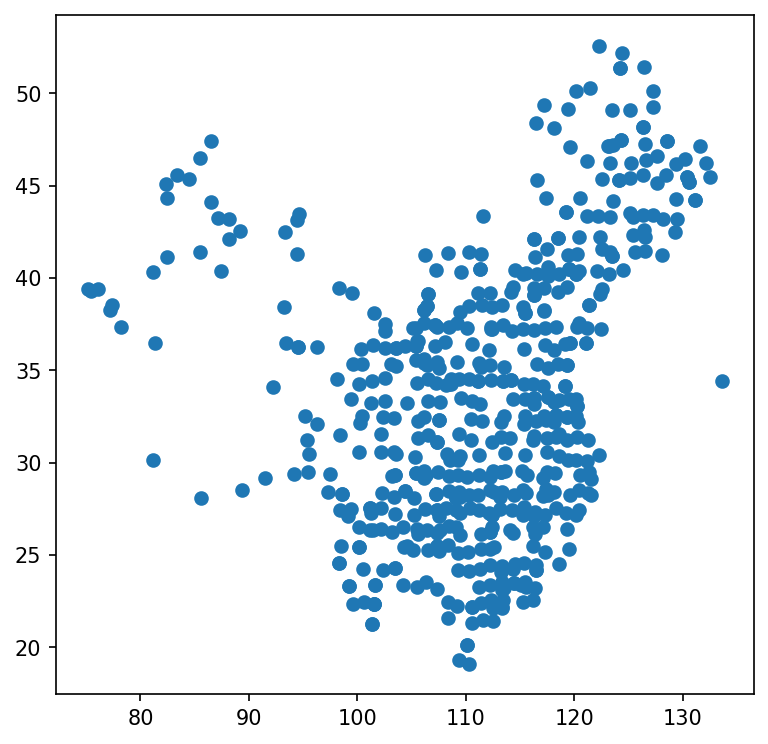

In [170]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=150)
ax.scatter(clean_data['longitude'], clean_data['latitude'])

## 筛选安徽省的数据

In [222]:
from getchinamap import getchinamap

china_engine = getchinamap.DownloadChmap()
prov_gpd = china_engine.download_province(province_name='安徽省', target='边界')
# prov_gpd = china_engine.download_country(target='边界')

prov_gpd

,adcode,name,childrenNum,level,parent,geometry
0,340000,安徽省,16,province,{'adcode': 100000},"POLYGON ((115.50863 32.46856, 115.49672 32.493..."


In [223]:
prov_gpd_valid = prov_gpd.copy()
prov_gpd_valid['geometry'] = prov_gpd_valid.buffer(0)

In [224]:
from shapely.geometry import Point


def detect_pic(x):
    return prov_gpd_valid.contains(Point(x['longitude'], x['latitude']))[0]


def detect_pic_inrect(x):
    bounds_ = prov_gpd_valid.bounds.iloc[0, :]
    minx, miny, maxx, maxy = bounds_.minx, bounds_.miny, bounds_.maxx, bounds_.maxy
    return (minx <= x['longitude']) & (x['longitude'] <= maxx) & (x['latitude'] >= miny) & (x['latitude'] <= maxy)


# clean_data['in_geo'] = clean_data.apply(lambda x: detect_pic(x), axis=1)
clean_data['in_box'] = clean_data.apply(lambda x: detect_pic_inrect(x), axis=1)

In [225]:
prov_pointer_df = clean_data.loc[clean_data['in_box']].reset_index(drop=True)
prov_pointer_df

,latitude,longitude,avg_temp,in_box
0,29.43,118.17,221.903226,True
1,29.51,117.43,211.741935,True
2,29.54,115.13,219.935484,True
3,30.13,119.42,210.096774,True
4,30.37,118.59,212.709677,True
5,30.44,115.40,214.548387,True
6,30.59,117.51,224.161290,True
7,31.24,116.19,213.451613,True
8,31.26,119.30,214.677419,True
9,31.35,117.50,217.000000,True


(29.395253, 34.650809)

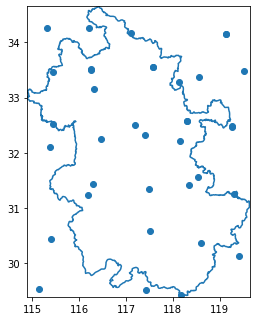

In [226]:
fig, ax = plt.subplots(figsize=(4, 6))
ax.scatter(prov_pointer_df['longitude'], prov_pointer_df['latitude'])
# ax.scatter(clean_data['longitude'], clean_data['latitude'])
prov_gpd_valid.boundary.plot(ax=ax)
ax.set_xlim(prov_gpd_valid.bounds.minx[0], prov_gpd_valid.bounds.maxx[0])
ax.set_ylim(prov_gpd_valid.bounds.miny[0], prov_gpd_valid.bounds.maxy[0])


In [227]:
prov_gpd_valid.bounds

,minx,miny,maxx,maxy
0,114.883371,29.395253,119.649144,34.650809


In [228]:
prov_gpd_valid.bounds.minx[0]

114.883371

In [229]:
bounds_ = prov_gpd_valid.bounds.iloc[0, :]
minx, miny, maxx, maxy = bounds_.minx, bounds_.miny, bounds_.maxx, bounds_.maxy

In [233]:
longitude_x = np.linspace(start=minx, stop=maxx, num=100)
latitude_y = np.linspace(start=miny, stop=maxy, num=200)

# grid_x, grid_y = np.meshgrid(longitude_x, latitude_y)
# grid_x_list = grid_x.reshape(-1,1)
# grid_y_list = grid_y.reshape(-1, 1)
# grid_df = pd.DataFrame({'grid_x_list':grid_x_list.flatten(), 'grid_y_list':grid_y_list.flatten()})
# grid_df

In [234]:
from scipy import interpolate
# f = interpolate.interp2d(prov_pointer_df['longitude'], prov_pointer_df['latitude'], prov_pointer_df['avg_temp'], kind='quintic')
f = interpolate.interp2d(clean_data['longitude'], clean_data['latitude'], clean_data['avg_temp'], kind='quintic')
# f = interpolate.interp2d(clean_data['longitude'], clean_data['latitude'], clean_data['avg_temp'], kind='cubic')

# f(grid_df['grid_x_list'], grid_df['grid_y_list'])
predict_cubic = f(longitude_x, latitude_y)
predict_cubic.shape

/opt/anaconda3/envs/devc/lib/python3.8/site-packages/scipy/interpolate/_fitpack_impl.py:977: RuntimeWarning: A theoretically impossible result when finding a smoothing spline
with fp = s. Probable causes: s too small or badly chosen eps.
(abs(fp-s)/s>0.001)
	kx,ky=5,5 nx,ny=29,26 m=560 fp=18753455.445441 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


(200, 100)

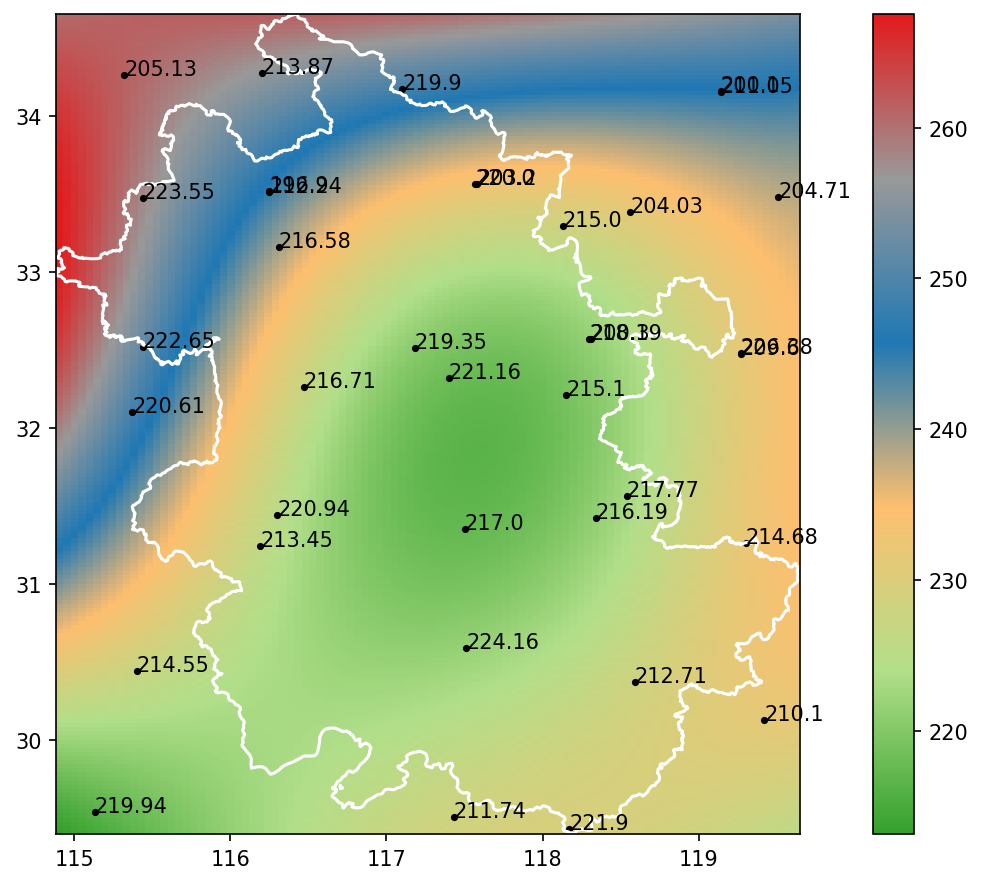

In [246]:
import matplotlib as mpl
from matplotlib import cm
fig, ax = plt.subplots(figsize=(10, 6), dpi=150)
colors = ["#33A02C", "#B2DF8A", "#FDBF6F", "#1F78B4", "#999999", "#E31A1C"]
# ax.scatter(clean_data['longitude'], clean_data['latitude'], c='red')
prov_gpd_valid.boundary.plot(ax=ax, color='white')
# ax_im_bar = ax.contourf(grid_x, grid_y, predict_cubic,cmap=cm.coolwarm) #mpl.colors.LinearSegmentedColormap.from_list("mypalette", colors, N=1000)

ax_im_bar = ax.imshow(predict_cubic, origin='lower',
                      extent=(minx, maxx,miny, maxy),
                      cmap=mpl.colors.LinearSegmentedColormap.from_list("mypalette", colors, N=1000))
# ax.contour(grid_x, grid_y, predict_cubic)
ax.scatter(prov_pointer_df['longitude'], prov_pointer_df['latitude'], c='black', s=6)

for index in range(prov_pointer_df.shape[0]):
    ax.text(prov_pointer_df.iloc[index]['longitude'], prov_pointer_df.iloc[index]['latitude'],np.around(prov_pointer_df.iloc[index]['avg_temp'], 2), c='black')
#
# ax.set_xlim(prov_gpd_valid.bounds.minx[0], prov_gpd_valid.bounds.maxx[0])
# ax.set_ylim(prov_gpd_valid.bounds.miny[0], prov_gpd_valid.bounds.maxy[0])
fig.colorbar(ax_im_bar, orientation='vertical')
plt.tight_layout()
plt.savefig("结果/result012901.png")